# Interesting Papers

https://www.sciencedirect.com/science/article/pii/S0960077920303246?casa_token=g3PE29gmlPYAAAAA:Me4yIHdPkev1fSpsUuW0CkhVwXr4aH3cUHNkj__WwSZt6XGA1Nmk6wUEDMshkHyOCiLcwYY#sec0002

https://www.jstor.org/stable/4576118?seq=4

https://nzmj.org.nz/media/pages/journal/vol-131-no-1487/new-zealand-s-experience-of-the-1918-19-influenza-pandemic-a-systematic-review-after-100-years/ef4958102b-1696475878/new-zealand-s-experience-of-the-1918-19-influenza-pandemic-a-systematic-review-after-100-years.pdf

https://www.sciencedirect.com/science/article/pii/S1755436511000053

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import pandas as pd
from scipy.optimize import curve_fit
from datetime import datetime
import numpy.typing as npt
from scipy.optimize import minimize
import numpy.typing as npt

In [193]:
from SEIRD_model_files import SEIRD_model 
from SEIRD_model_files import SEIRD_fitting
#import importlib
#importlib.reload(SEIRD_model)
importlib.reload(SEIRD_fitting)

<module 'SEIRD_model_files.SEIRD_fitting' from '/home/gavin/Documents/NZ_data/SEIRD_model_files/SEIRD_fitting.py'>

# Generalized multi-population SEIRD Model 

The number of susceptible $S$, infectious $I$, recovered $R$, and deceased (or non-interacting) $D$ for a given population group $g$ is stored in the Y matrix: $Y^{g}_{c}$, where $g$ is the population (stored in rows), and $c$ is the category ($S^g$, $E^g$, $I^g$, $R^g$ or $D^g$). Thus, in this case $Y$ is an $N$ by 5 matrix, where $N$ is the number of different populations. 

The $\theta$ matrix contains information about how the populations mix. It is an $N$ by $N$ matrix $\theta^i_g$, each element of which has the proportion of population group $g$ that spend that timestep in mixing environment $i$. It can also be thought of as the probability that a person from population $g$ will spend time in mixing environment $m$. $\sum_{m} \theta^m_g = 1$. 

$$ \sum_{g} \theta^m_g ~ Y^{g}_{c} = B^{m}_{c}, $$

where $B^m_c$ is an $M$ by 5 matrix of the number of people in mixing environment $m$ (e.g. young-people env, old folk env) that are of type $c$ (susceptible, exposed, infectious, recovered, or dead). 

The number of new infections in a particular group $g$ depends on their exposure to infectious people while visiting another population's environment, plus the exposure encountered by those who stayed. 

\begin{align}
\text{New Infections for those of type $g$ going to mixing environment }m &= \text{\# susceptible who go} \times \beta_m \times \frac{\text{\# infectious in }m}{\text{total \# in }m}, \\
&= S^g\theta^m_g \times \beta_m \times \frac{B^m_{\text{infectious}}}{B^m_{\text{susceptible}} + B^m_{\text{exposed}} + B^m_{\text{infectious}} + B^m_{\text{recovered}}}.
\end{align}

Thus, the total number of infections can be calculated:
\begin{align}
\text{New Infections for those in group }g &= \sum_{\text{places visited } m}\text{\# susceptible from $g$ who went to }m \times \beta_m \times \frac{\text{\# infectious in }m}{\text{total \# in }m}, \\
\frac{\text{d}E_g}{\text{d}t} &= Y^g_S \sum_{m} \theta^m_g  \beta_m \times \frac{B^m_{\text{infectious}}}{B^m_{\text{susceptible}} + B^m_{\text{exposed}} + B^m_{\text{infectious}} + B^m_{\text{recovered}}},\\
&=  Y^g_S\sum_{m}\theta^m_g\beta_m \frac{\sum_{g'}\theta^m_{g'} ~ Y^{g'}_{I}}{\sum_{g''}\sum_{c=S,E,I,R} \theta^m_{g''} ~ Y^{g''}_{c}}, \\
\end{align}

A deliberate choice is made here to removed the dead from the population. The logic here is that when folk visit somewhere, they are not mixing with the dead. Thus, dead folk do not reduce the propensity for infection --- they simply are removed from the overall population. However, the number of dead is so small this is probably a small perturbation. 



### Setting the parameters for an example coupled SEIRD model

Creates the `theta_matrix` in a standardised way from an array of arguments 

In [118]:
# The SIRD matrix on the first day of infection
Y_matrix_0 = np.array([[499000, 0, 100, 0, 0],
                       [160000, 0, 0, 0, 0]])

# The total number of people in each population
N_vector = Y_matrix_0.sum(axis=1)

def build_theta_method(*args) -> npt.NDArray:
        """Builds the theta matrix from a series of arguments. 
    
        Args:
          The parameters that go into the theta matrix. 
    
        Returns:
          theta_matrix (npt.NDArray): 
            The matrix $\theta^i_g$ that couples population groups $g$ to mixing environments $i$. 
            Should be shape $M\times N$, where $M$ is the number of mixing environments and $N$ the number of pop groups. 
        """
        theta_matrix = np.array([[   args[0],    args[1]],
                                 [1.-args[0], 1.-args[1]]])
        return theta_matrix

# the contact rate, beta, for each population
beta_vector = np.array([0.2, 0.4])
# The incubation_rate, recovery rate and death rate
latent_period, gamma, delta = [1.4*np.ones(Y_matrix_0.shape[0]), 
                               0.15, 
                               0.015*np.array([1.,1.])]

# the coupling matrix between the boxes. 
theta_matrix = build_theta_method( 0.9, 0.2)

print("Number of populations = {}\n".format(len(beta_vector)))
print(" Starting vector S,E,I,R,D for each population = \n",Y_matrix_0)

print("\nParameters:\n beta_vector = ",beta_vector)
print(" gamma = {},\n delta = {},\n".format(gamma, delta))
print(" latent period = {},\n".format(latent_period))
print(" theta_matrix = \n",theta_matrix)

# the time points (days) over which we want to predict using our model
t = np.linspace(0, 400, 8000)

print("\n\nReady to go!")

Number of populations = 2

 Starting vector S,E,I,R,D for each population = 
 [[499000      0    100      0      0]
 [160000      0      0      0      0]]

Parameters:
 beta_vector =  [0.2 0.4]
 gamma = 0.15,
 delta = [0.015 0.015],

 latent period = [1.4 1.4],

 theta_matrix = 
 [[0.9 0.2]
 [0.1 0.8]]


Ready to go!


In [119]:
my_SEIRD = SEIRD_model.SEIRD_model(beta_vector, gamma, delta, latent_period, theta_matrix)
my_SEIRD.group_names = ['Young', 'Old']

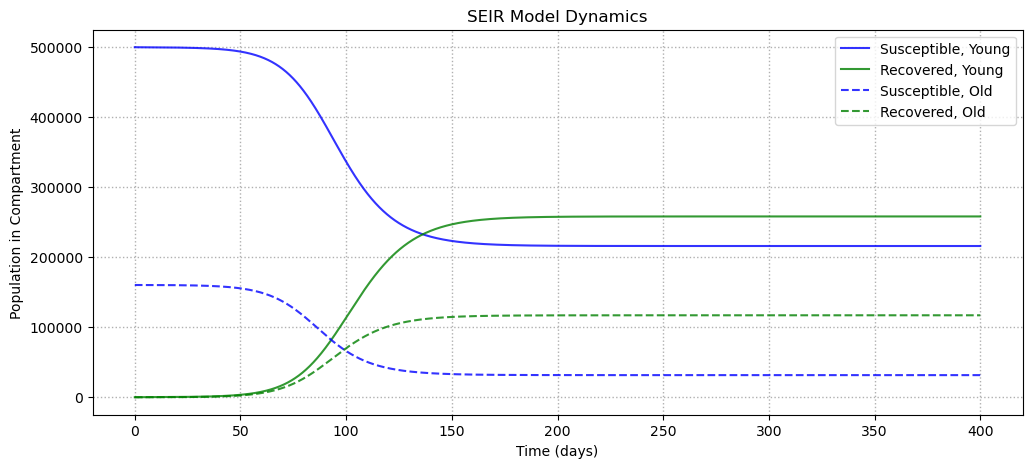

In [120]:
my_SEIRD.plot_Y_t(t,Y_matrix_0, compartments_to_plot=[0,3])

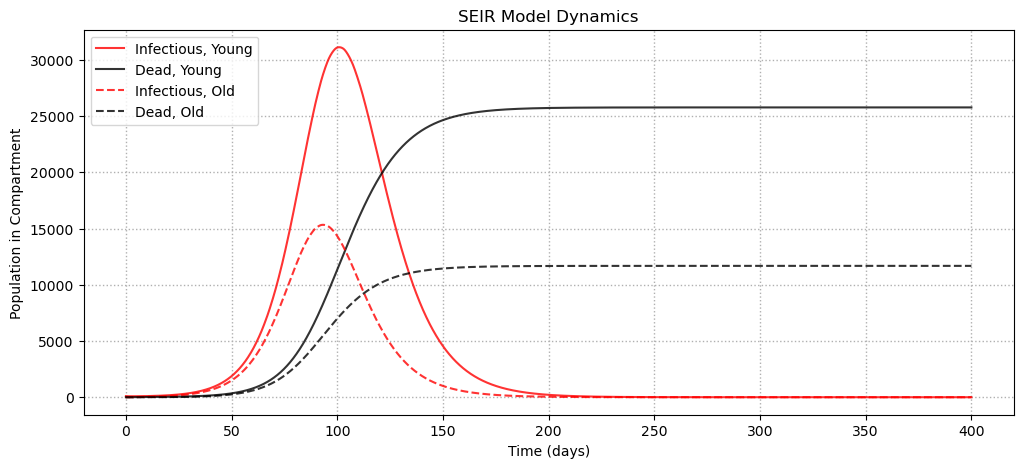

In [121]:
my_SEIRD.plot_Y_t(t,Y_matrix_0, compartments_to_plot=[2,4])

## Observations:

1) It seems that the only way of reducing the overall number of deaths in a category is to reduce the infectiousness $\beta$ for that compartment. If that happens, the overall number of dead in the limit of large $t$ is lower (although there is a larger number of susceptible left at the end).

2) If the coupling $\theta$ is very small, then having different infectivities $\beta$ for each environment is relevant. However, the larger $\theta$ is, the less different $\beta$ values matter. As expected, $\theta = 0$ gives completely decoupled populations, and $\theta = 0.5$ gives perfectly mixed populations. $\theta > 0.5$ has an interesting swapover, where the "old" population spend most of their time in a high$\beta$ environment, and thus actually die more.

3) It ultimately works on the idea that the disease dies out before the entire population is infected due to herd immunity. If the whole population gets infected, then the total number of deaths will be the same in the long run.

4) Theta does not need to be symmetric, i.e. the outcome when $\theta_{yo}$ and $\theta_{oy}$ are switched is not the same. Indeed if $\beta$ is not the same for both populations, then $\theta$ being switched changes the curves significantly. 

### Generating artificial data for fitting

Generate some data with a little noise. This is for fitting tests.

(<matplotlib.legend.Legend at 0x7fca62c42ad0>,
 Text(0.5, 0, 'Date'),
 Text(0, 0.5, 'Deaths per day'))

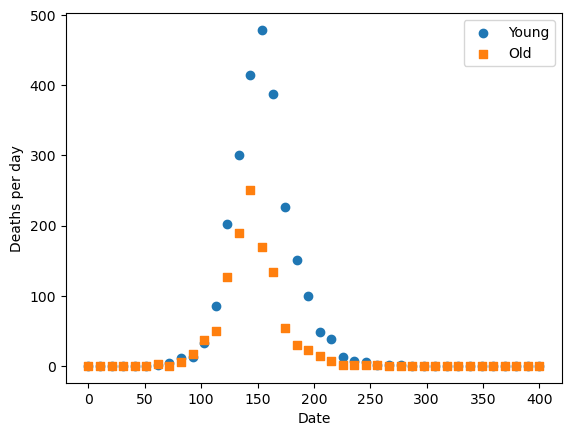

In [123]:
t_sparse = np.linspace(0,400, 40) # dates over which to do things

deaths_per_day = my_SEIRD.compute_derivs_per_day(t_sparse,
                           50, # day of first infection
                           Y_matrix_0)[:,4,:]

from numpy.random import poisson
shifted_fake_deaths_per_day = poisson(deaths_per_day)
#shifted_fake_deaths_per_day = deaths_per_day

plt.scatter(t_sparse, shifted_fake_deaths_per_day[0], label='Young')
plt.scatter(t_sparse, shifted_fake_deaths_per_day[1], marker='s', label='Old')
plt.legend(), plt.xlabel('Date'), plt.ylabel('Deaths per day')

# 2D version fitting Proof of Concept

Going to generate data from the 2D version and fit that. 

In [199]:
class ModelHandler:
    """Class to communicate between fitting methods defined in SEIRD_fitting, and models defined in SEIRD_model.

    Should be changed each time dimensions of Y_0 are changed or the number of mixing environments is changed. 
    """
    def __init__(self,
                 seird_model,
                 date_of_first_infection,
                 dates,
                 Y_0):
        self.seird_model = seird_model
        self.date_of_first_infection = date_of_first_infection
        self.dates = dates
        self.fitting_params = self.get_fitting_params_from_model()
        self.Y_0 = Y_0

    def get_derivs_per_day(self):
        """Should rarely be a need to change"""
        return self.seird_model.compute_derivs_per_day(self.dates,
                                                       self.date_of_first_infection,
                                                       self.Y_0)
        
    def get_fitting_params_from_model(self):
        """Sets how fitting parameters are related to the model attributes.

        Should be altered each time a new number of parameters is set, e.g. changing the number of groups or mixing environments. 
        """
        return [self.date_of_first_infection,
                self.seird_model.beta_vector[0],
                self.seird_model.beta_vector[1],
                self.seird_model.gamma,
                self.seird_model.delta[0],
                self.seird_model.theta_matrix[0,0],
                self.seird_model.theta_matrix[0,1]]
    
    def set_fitting_params_for_model(self, params):
        """Setting how the models parameters change.
        
        Should be altered each time a new number of parameters is changed, or the number of mixing environments, etc.
        """
        self.date_of_first_infection  = params[0]
        self.seird_model.beta_vector  = [params[1], params[2]]
        self.seird_model.gamma        = params[3]
        self.seird_model.delta        = params[4]*np.ones(self.seird_model.num_groups)
        self.seird_model.theta_matrix = ModelHandler.build_theta_matrix(params[5], params[6])
    
    @staticmethod
    def build_theta_matrix(*args) -> npt.NDArray:
        """Builds the theta matrix from a series of arguments. 
    
        Args:
          If first argument is 'Default', the args should be
          the parameters that go into the theta matrix.
          Otherwise args[0], then it should be a function to call and pass the rest of the arguments to. Can be an externally defined function, held as self.theta_matrix_building_method. 
    
        Returns:
          theta_matrix (npt.NDArray): 
            The matrix $\theta^i_g$ that couples population groups $g$ to mixing environments $i$. 
            Should be shape $M\times N$, where $M$ is the number of mixing environments and $N$ the number of pop groups. 
        """
        theta_matrix = np.array([[   args[0],    args[1]],
                                 [1.-args[0], 1.-args[1]]])
        return theta_matrix

Initial guesses for the fit

In [174]:
# Day of the first infection
day_of_start_0 = 60
# The distribution of the population across compartments and groups on the first day of infection.
Y_day_0_of_infection = Y_matrix_0 
# Transmission coefficients for each mixing environment
beta_vector_0 = np.array([0.25, 0.45])
# Recovery rate and death rate
gamma_0 = 0.18
delta_0 = gamma_0*0.1*np.array([1.,1.])
# the coupling matrix between the boxes. 
theta_y1_0 , theta_o1_0 = 0.85 , 0.13
# The mean length of time between exposure and infectiousness
latent_period = latent_period #1.4
# the coupling matrix between the boxes. 
theta_matrix_0 = ModelHandler.build_theta_matrix(theta_y1_0, theta_o1_0)

y_data = shifted_fake_deaths_per_day
sigma_y = np.maximum(np.ones(shifted_fake_deaths_per_day.shape), np.sqrt(shifted_fake_deaths_per_day))

bounds = [(30, 70), # day of 1st infection
          (0.0, 1.0), # beta_1
          (0.0, 1.0), # beta_2
          (0.01, 1.0), # gamma
          (0.0001, 0.3), # deathrate
          (0.0, 1.0), # theta_y1
          (0.0, 1.0)] # theta_o1

print("Initial guesses for the SEIRD model parameters:\n")
print("Day of start of infection = {}\n".format(day_of_start_0))
print(" Starting vector = \n",Y_day_0_of_infection)
print("\nParameters:\n beta_vector = ",beta_vector_0)
print(" gamma = {},\n delta = {},\n".format(gamma_0, delta_0))
print(" latent period = {},\n".format(latent_period))
print(" theta_matrix = \n",theta_matrix_0)

Initial guesses for the SEIRD model parameters:

Day of start of infection = 60

 Starting vector = 
 [[499000      0    100      0      0]
 [160000      0      0      0      0]]

Parameters:
 beta_vector =  [0.25 0.45]
 gamma = 0.18,
 delta = [0.018 0.018],

 latent period = [1.4 1.4],

 theta_matrix = 
 [[0.85 0.13]
 [0.15 0.87]]


In [175]:
my_model = SEIRD_model.SEIRD_model(beta_vector_0, gamma_0, delta_0, latent_period, theta_matrix_0)

my_model_handler = ModelHandler(my_model, # SEIRD_model object
                                day_of_start_0, # day of first infection
                                t_sparse, # list of dates being used
                                Y_day_0_of_infection) # Y_0 

my_fit = SEIRD_fitting.fitting_deaths(t_sparse,
                                      y_data,
                                      sigma_y=sigma_y,
                                      seird_model=my_model,
                                      bounds=bounds,
                                     model_handler = my_model_handler)

In [204]:
my_fit.fitting_params , my_fit.bounds

([60,
  np.float64(0.25),
  np.float64(0.45),
  np.float64(0.18),
  np.float64(0.018),
  np.float64(0.85),
  np.float64(0.13)],
 [(30, 70),
  (0.0, 1.0),
  (0.0, 1.0),
  (0.01, 1.0),
  (0.0001, 0.3),
  (0.0, 1.0),
  (0.0, 1.0)])

Plot the initial guess

Xi value = 11.458997774712127


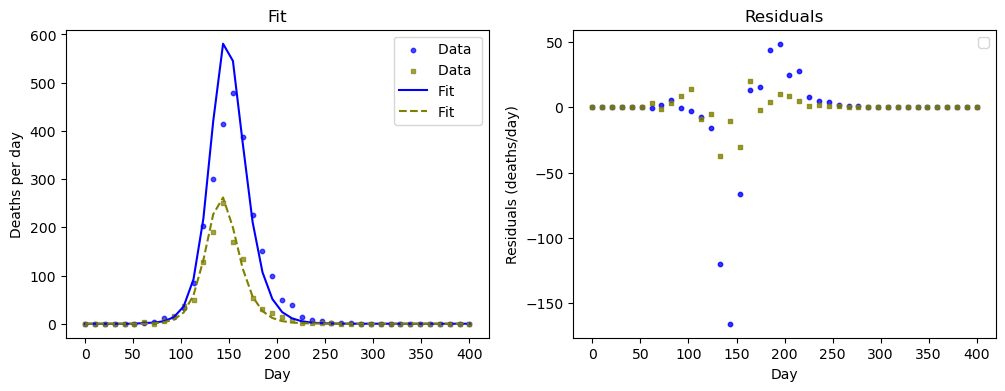

In [205]:
my_fit.plot_fit()

Run the fit

In [212]:
%%time
my_fit.do_minimize()
print(my_fit.opt)

       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 4.998706933717067
             x: [ 5.128e+01  2.563e-01  4.011e-01  1.791e-01  1.857e-02
                  9.346e-01  1.326e-01]
           nit: 1542
          nfev: 2502
 final_simplex: (array([[ 5.128e+01,  2.563e-01, ...,  9.346e-01,
                         1.326e-01],
                       [ 5.128e+01,  2.563e-01, ...,  9.346e-01,
                         1.326e-01],
                       ...,
                       [ 5.128e+01,  2.563e-01, ...,  9.346e-01,
                         1.326e-01],
                       [ 5.128e+01,  2.563e-01, ...,  9.346e-01,
                         1.326e-01]], shape=(8, 7)), array([ 4.999e+00,  4.999e+00,  4.999e+00,  4.999e+00,
                        4.999e+00,  4.999e+00,  4.999e+00,  4.999e+00]))
CPU times: user 1min 49s, sys: 21.2 ms, total: 1min 49s
Wall time: 1min 50s


In [213]:
my_fit.fitting_params

array([5.12820513e+01, 2.56298868e-01, 4.01133169e-01, 1.79146883e-01,
       1.85720810e-02, 9.34573249e-01, 1.32565894e-01])

Plot after the fit

Xi value = 4.998706933717198


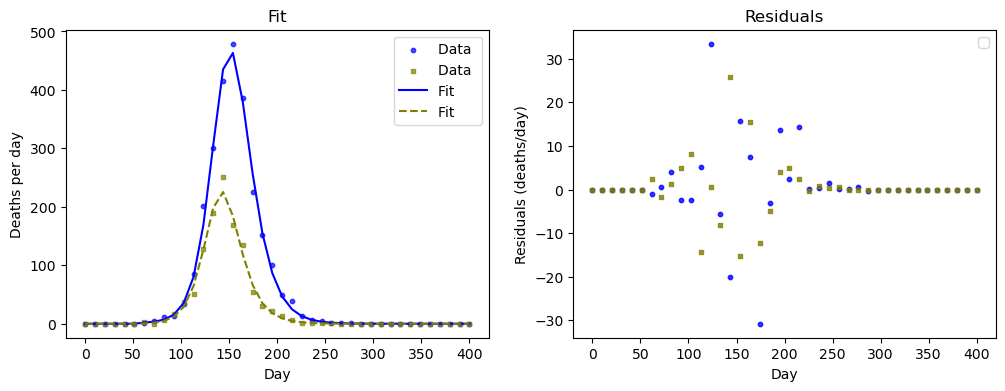

In [214]:
my_fit.plot_fit()

In [215]:
day_of_first_infection_fit, beta_fit_1, beta_fit_2, theta_y1_fit, theta_o1_fit, gamma_fit, delta_fit = my_fit.opt.x
print("Final fitted parameters are:")
print("   day zero = {:.2g} ,".format(day_of_first_infection_fit))
print("   beta_1   = {:.3g} ,".format(beta_fit_1))
#print("   beta_m   = {:.3g} ,".format(beta_fit_mid))
print("   beta_2   = {:.3g} ,".format(beta_fit_2))
print("   gamma    = {:.3g} ,".format(gamma_fit)) 
print("   delta    = {:.3g} ,".format(delta_fit))
print("   theta_y1 = {:.3g} ,".format(theta_y1_fit))
print("   theta_o1 = {:.3g} ,\n".format(theta_o1_fit))

Final fitted parameters are:
   day zero = 51 ,
   beta_1   = 0.256 ,
   beta_2   = 0.401 ,
   gamma    = 0.935 ,
   delta    = 0.133 ,
   theta_y1 = 0.179 ,
   theta_o1 = 0.0186 ,



# Training the model on NZ data

We're going to do it with some ages, and the aim to get the $t \rightarrow \infty$ limit for the number of deaths equal to the total number of deaths of the age ranges and sexes.

But, for starters, we'll just train the simple SEIRD model on NZ data. 



In [216]:
NZ_death_data = pd.read_csv('deaths_by_age_and_date.csv').drop(columns=['Unnamed: 0'])
NZ_death_data.loc[:,'Total'] = NZ_death_data.loc[:,'0-19']+NZ_death_data.loc[:,'20-49']+NZ_death_data.loc[:,'50+']
NZ_death_data

,date_death,military_binary,0-19,20-49,50+,Total
0,1918-09-01 00:00:00,Y,0,1,0,1
1,1918-09-02 00:00:00,Y,0,6,0,6
2,1918-09-03 00:00:00,Y,0,4,0,4
3,1918-09-04 00:00:00,Y,0,23,0,23
4,1918-09-05 00:00:00,Y,1,15,0,16
...,...,...,...,...,...,...
147,1919-02-22 00:00:00,Y,0,2,0,2
148,1919-02-23 00:00:00,Y,0,1,0,1
149,1919-02-24 00:00:00,Y,0,2,0,2
150,1919-02-25 00:00:00,Y,0,3,0,3


In [217]:
N_0_19 , N_20_49, N_50p =  455502, 481145, 161536  # from age census data 1916
N_T = N_0_19 + N_20_49 + N_50p
print("From NZ census data 1916\n----------------------------\nNumber of 0 - 19:  {} ,\nNumber of 20 - 49: {} ,\nNumber of 50+:     {},\n     Total number :   {}".format(N_0_19, N_20_49, N_50p, N_T))

From NZ census data 1916
----------------------------
Number of 0 - 19:  455502 ,
Number of 20 - 49: 481145 ,
Number of 50+:     161536,
     Total number :   1098183


(Text(0.5, 0, 'Date'),
 Text(0, 0.5, 'Deaths per day'),
 <matplotlib.legend.Legend at 0x7fca628696d0>)

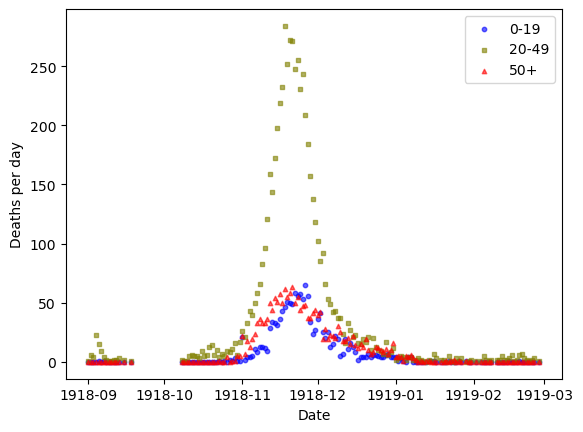

In [227]:
y_young = NZ_death_data.sort_values('date_death')['0-19']
y_mid   = NZ_death_data.sort_values('date_death')['20-49']
y_old   = NZ_death_data.sort_values('date_death')['50+']

y_data = np.array([y_young, y_mid, y_old])

sigma_data = np.maximum(np.ones(y_data.shape),np.sqrt(y_data))

xplot = pd.to_datetime(NZ_death_data.sort_values('date_death').loc[:,'date_death'])
dummy = xplot
dummymin = min(xplot)
x_data = dummy.apply(lambda l: l - dummymin).dt.days

plt.scatter(xplot, y_young, color='blue', marker='o', label='0-19', alpha=.6, s=10)
plt.scatter(xplot, y_mid, color='olive', marker='s', label='20-49', alpha=.6, s=10)
plt.scatter(xplot, y_old, color='red', marker='^', label='50+', alpha=.6, s=10)
plt.xlabel('Date'), plt.ylabel('Deaths per day'), plt.legend()

# Fitting the matrix version

In [221]:
class ModelHandler:
    """Class to communicate between fitting methods defined in SEIRD_fitting, and models defined in SEIRD_model.

    Should be changed each time dimensions of Y_0 are changed or the number of mixing environments is changed. 
    """
    def __init__(self,
                 seird_model,
                 date_of_first_infection,
                 dates,
                 Y_0):
        self.seird_model = seird_model
        self.date_of_first_infection = date_of_first_infection
        self.dates = dates
        self.fitting_params = self.get_fitting_params_from_model()
        self.Y_0 = Y_0

    def get_derivs_per_day(self):
        """Should rarely be a need to change"""
        return self.seird_model.compute_derivs_per_day(self.dates,
                                                       self.date_of_first_infection,
                                                       self.Y_0)
        
    def get_fitting_params_from_model(self):
        """Sets how fitting parameters are related to the model attributes.

        Should be altered each time a new number of parameters is set, e.g. changing the number of groups or mixing environments. 
        """
        return [self.date_of_first_infection,
                self.seird_model.beta_vector[0],
                self.seird_model.beta_vector[1],
                self.seird_model.gamma,
                self.seird_model.delta[0],
                self.seird_model.theta_matrix[0,0],
                self.seird_model.theta_matrix[0,1]]
    
    def set_fitting_params_for_model(self, params):
        """Setting how the models parameters change.
        
        Should be altered each time a new number of parameters is changed, or the number of mixing environments, etc.
        """
        self.date_of_first_infection  = params[0]
        self.seird_model.beta_vector  = [params[1], params[2]]
        self.seird_model.gamma        = params[3]
        self.seird_model.delta        = params[4]*np.array([1.,1.,2.])
        self.seird_model.theta_matrix = ModelHandler.build_theta_matrix(params[5], params[6])
    
    @staticmethod
    def build_theta_matrix(*args) -> npt.NDArray:
        """Builds the theta matrix from a series of arguments. 
    
        Args:
          If first argument is 'Default', the args should be
          the parameters that go into the theta matrix.
          Otherwise args[0], then it should be a function to call and pass the rest of the arguments to. Can be an externally defined function, held as self.theta_matrix_building_method. 
    
        Returns:
          theta_matrix (npt.NDArray): 
            The matrix $\theta^i_g$ that couples population groups $g$ to mixing environments $i$. 
            Should be shape $M\times N$, where $M$ is the number of mixing environments and $N$ the number of pop groups. 
        """
        theta_matrix = np.array([[   args[0],    args[1], args[0]],
                                 [1.-args[0], 1.-args[1], 1.-args[0]]])
        return theta_matrix

In [229]:
Y_day_0_of_infection = np.array([[455502, 0, 0, 0, 0],
                                 [481145-10, 0, 10, 0, 0],
                                 [161536, 0, 0, 0, 0]])

gamma_0, delta_0 = 0.3, 0.006*np.array([1.,1.,2.])

beta_vector_0 = [0.3, 0.7]

latent_period = 1.4

theta_yo_0, theta_oy_0 = 0.85, 0.15
theta_matrix_0 = ModelHandler.build_theta_matrix( theta_yo_0, theta_oy_0)

day_of_first_infection_0 = 10

bounds=[(0,60), (0.,1.), (0.,2.0), (0.01,1.), (0.000, 0.1), (0.,1.), (0.,1.)]

In [232]:
my_model = SEIRD_model.SEIRD_model(beta_vector_0, gamma_0, delta_0, latent_period, theta_matrix_0)

my_model_handler = ModelHandler(my_model, # SEIRD_model object
                                day_of_first_infection_0, # day of first infection
                                x_data, # list of dates being used
                                Y_day_0_of_infection) # Y_0 

my_fit = SEIRD_fitting.fitting_deaths(x_data,
                                      y_data,
                                      sigma_y=sigma_data,
                                      seird_model=my_model,
                                      bounds=bounds,
                                     model_handler = my_model_handler)

Xi value = 70.55119628554996


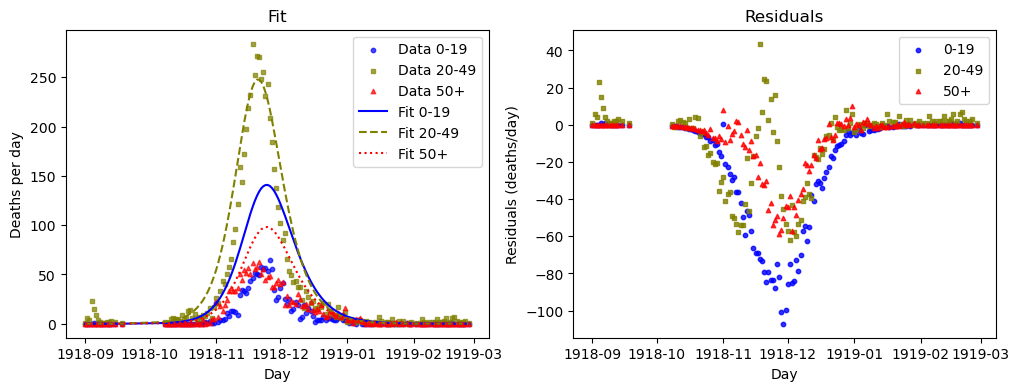

In [233]:
my_fit.plot_fit(labellist=['0-19','20-49','50+'], xplot=xplot)

In [235]:
%%time
my_fit.do_minimize()
my_fit.opt

CPU times: user 2min 6s, sys: 25.7 ms, total: 2min 6s
Wall time: 2min 6s


       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 20.09150476837318
             x: [ 2.698e+01  2.223e-09  8.988e-01  3.155e-01  4.380e-03
                  8.750e-01  1.430e-01]
           nit: 2431
          nfev: 3831
 final_simplex: (array([[ 2.698e+01,  2.223e-09, ...,  8.750e-01,
                         1.430e-01],
                       [ 2.698e+01,  2.223e-09, ...,  8.750e-01,
                         1.430e-01],
                       ...,
                       [ 2.698e+01,  2.223e-09, ...,  8.750e-01,
                         1.430e-01],
                       [ 2.698e+01,  2.223e-09, ...,  8.750e-01,
                         1.430e-01]], shape=(8, 7)), array([ 2.009e+01,  2.009e+01,  2.009e+01,  2.009e+01,
                        2.009e+01,  2.009e+01,  2.009e+01,  2.009e+01]))

In [236]:
my_fit.fitting_params

array([2.69794663e+01, 2.22346862e-09, 8.98788778e-01, 3.15474067e-01,
       4.38014277e-03, 8.74973701e-01, 1.42962384e-01])

Xi value = 20.09150476837319


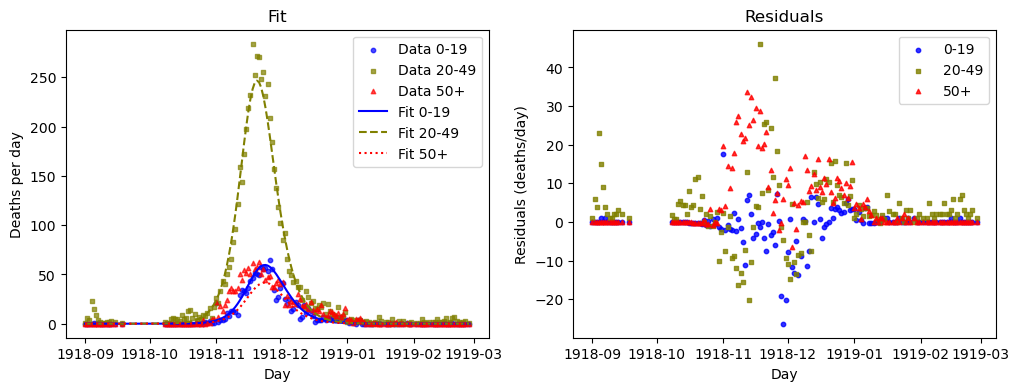

In [238]:
my_fit.plot_fit(labellist=['0-19','20-49','50+'], xplot=xplot)
#plt.savefig('Fit2.pdf')